In [1]:
## Standard libraries
import os
import json
import math
import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt

from deep_autoencoder_tutorial.training.train_cifar import train_cifar
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install pytorch-lightning==1.3.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Tensorboard extension (for visualization purposes later)
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial9"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

Global seed set to 42


In [2]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial9/"
# Files to download
pretrained_files = ["cifar10_64.ckpt", "cifar10_128.ckpt", "cifar10_256.ckpt", "cifar10_384.ckpt"]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print("Downloading %s..." % file_url)
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)


In [3]:
# Transformations applied on each image => only make them a tensor
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=transform, download=True)
pl.seed_everything(42)
train_set, val_set = torch.utils.data.random_split(train_dataset, [45000, 5000])


Files already downloaded and verified


Global seed set to 42


In [4]:
# Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=transform, download=True)



Files already downloaded and verified


In [5]:
# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=64, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=64, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=64, shuffle=False, drop_last=False, num_workers=4)

In [6]:
def get_train_images(num):
    return torch.stack([train_dataset[i][0] for i in range(num)], dim=0)


In [7]:
def compare_imgs(img1, img2, title_prefix=""):
    loss = F.mse_loss(img1, img2, reduction="sum")
    grid = torchvision.utils.make_grid(torch.stack([img1, img2], dim=0),
                                       nrow=2,
                                       normalize=True,
                                       range=(-1, 1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(4, 2))
    plt.title("%s Loss: %4.2f" % (title_prefix, loss.item()))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

In [8]:
## DEMONSTRATION OF MSE FAILURES

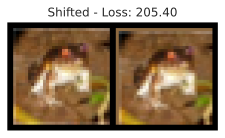

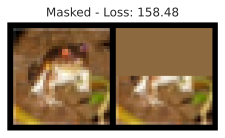

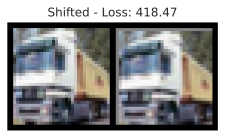

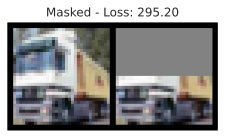

In [9]:
for i in range(2):
    # load example image
    img, _ = train_dataset[i]
    img_mean = img.mean(dim=[1, 2], keepdims=True)

    # shift image by 1 pixel
    SHIFT = 1
    img_shifted = torch.roll(img, shifts=SHIFT, dims=1)
    img_shifted = torch.roll(img_shifted, shifts=SHIFT, dims=2)
    img_shifted[:, :1, :] = img_mean
    img_shifted[:, :, :1] = img_mean
    compare_imgs(img, img_shifted, "Shifted -")

    # Shift image by one pixel
    img_masked = img.clone()
    img_masked[:,:img_masked.shape[1]//2,:] = img_mean
    compare_imgs(img, img_masked, "Masked -")

In [10]:
## Comparing Latent Dimensionality

In [11]:
model_dict = {}
# Commented out because my GPU have hard time contatining all 5 at the same time
#for latent_dim in [64, 128, 256, 384]:
for latent_dim in [64]:
    model_ld, result_ld = train_cifar(train_loader,
                                      val_loader,
                                      test_loader,
                                      latent_dim,
                                      get_train_images(8))
    model_dict[latent_dim] = {"model": model_ld, "result": result_ld}

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Found pretrained model, loading...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


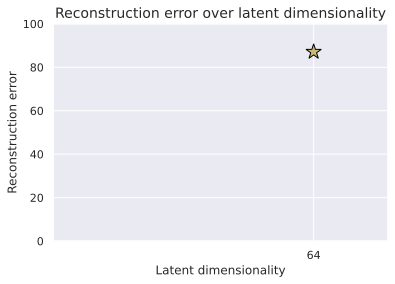

In [12]:
latent_dims = sorted([k for k in model_dict])
val_scores = [model_dict[k]["result"]["val"][0]["test_loss"] for k in latent_dims]

fig = plt.figure(figsize=(6,4))
plt.plot(latent_dims, val_scores, '--', color="#000", marker="*", markeredgecolor="#000", markerfacecolor="y", markersize=16)
plt.xscale("log")
plt.xticks(latent_dims, labels=latent_dims)
plt.title("Reconstruction error over latent dimensionality", fontsize=14)
plt.xlabel("Latent dimensionality")
plt.ylabel("Reconstruction error")
plt.minorticks_off()
plt.ylim(0,100)
plt.show()


In [13]:
## Visualizing Reconstructions

In [14]:
def visualize_reconstructions(model, input_imgs):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs = model(input_imgs.to(model.device))
    reconst_imgs = reconst_imgs.cpu()

    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(7,4.5))
    plt.title("Reconstructed from %i latents" % (model.hparams.latent_dim))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()


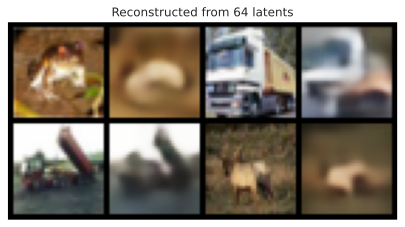

In [15]:
input_imgs = get_train_images(4)
for latent_dim in model_dict:
    visualize_reconstructions(model_dict[latent_dim]["model"], input_imgs)

In [16]:
## Generating new images

"""
As we can see, the generated images more look like art than realistic images.
 As the autoencoder was allowed to structure the latent space in whichever way it suits the reconstruction best,
  there is no incentive to map every possible latent vector to realistic images.
   Furthermore, the distribution in latent space is unknown to us
   and doesn’t necessarily follow a multivariate normal distribution.
    Thus, we can conclude that vanilla autoencoders are indeed not generative.
"""

'\nAs we can see, the generated images more look like art than realistic images.\n As the autoencoder was allowed to structure the latent space in whichever way it suits the reconstruction best,\n  there is no incentive to map every possible latent vector to realistic images.\n   Furthermore, the distribution in latent space is unknown to us\n   and doesn’t necessarily follow a multivariate normal distribution.\n    Thus, we can conclude that vanilla autoencoders are indeed not generative.\n'

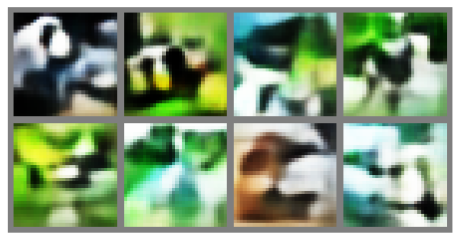

In [17]:
model = model_dict[64]["model"]
latent_vectors = torch.randn(8, model.hparams.latent_dim, device=model.device)
with torch.no_grad():
    imgs = model.decoder(latent_vectors)
    imgs = imgs.cpu()

grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, range=(-1, 1), pad_value=0.5)
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(8, 5))
plt.imshow(grid)
plt.axis('off')
plt.show()

In [18]:
## Finding visually similar images

In [19]:
# We use the following model throughout this section.
# If you want to try a different latent dimensionality, change it here!
model = model_dict[64]["model"]

In [19]:
def embed_imgs(model, data_loader):
    # Encode all images in the data_laoder using model, and return both images and encodings
    img_list, embed_list = [], []
    model.eval()
    counter = 0
    for imgs, _ in tqdm(data_loader, desc="Encoding images", leave=False):
        if counter > 50:
            break
        with torch.no_grad():
            z = model.encoder(imgs.to(model.device))
        img_list.append(imgs)
        embed_list.append(z)
        counter += 1
    return (torch.cat(img_list, dim=0), torch.cat(embed_list, dim=0))

In [20]:
train_img_embeds = embed_imgs(model, train_loader)
test_img_embeds = embed_imgs(model, test_loader)


In [21]:
def find_similar_images(query_img, query_z, key_embeds, K=8):
    # Find closest K images. We use the euclidean distance here but other like cosine distance can also be used.
    dist = torch.cdist(query_z[None,:], key_embeds[1], p=2)
    dist = dist.squeeze(dim=0)
    dist, indices = torch.sort(dist)
    # Plot K closest images
    imgs_to_display = torch.cat([query_img[None], key_embeds[0][indices[:K]]], dim=0)
    grid = torchvision.utils.make_grid(imgs_to_display, nrow=K+1, normalize=True, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(12,3))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

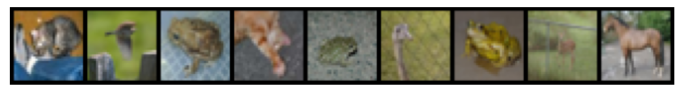

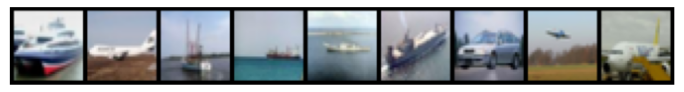

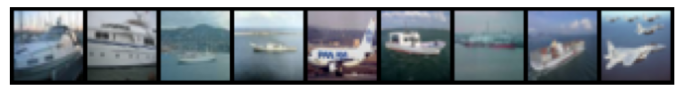

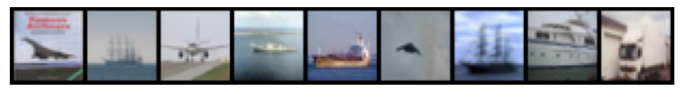

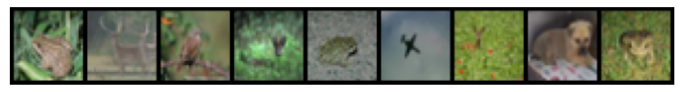

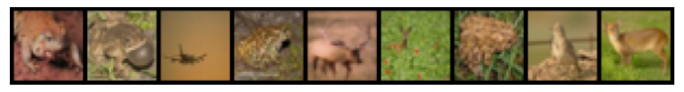

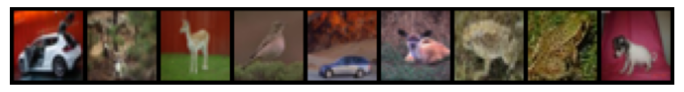

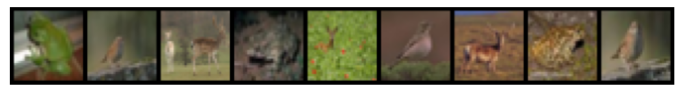

In [22]:
# Plot the closest images for the first N test images as example
for i in range(8):
    find_similar_images(test_img_embeds[0][i], test_img_embeds[1][i], key_embeds=train_img_embeds)


In [23]:
## Tensorboard clustering

In [24]:
# We use the following model throughout this section.
# If you want to try a different latent dimensionality, change it here!
model = model_dict[64]["model"]

In [27]:
# Create a summary writer
writer = SummaryWriter("tensorboard/")


In [28]:
# Note: the embedding projector in tensorboard is computationally heavy.
# Reduce the image amount below if your computer struggles with visualizing all 10k points
NUM_IMGS = 50 #len(test_set)

writer.add_embedding(test_img_embeds[1][:NUM_IMGS], # Encodings per image
                     metadata=[test_set[i][1] for i in range(NUM_IMGS)], # Adding the labels per image to the plot
                     label_img=(test_img_embeds[0][:NUM_IMGS]+1)/2.0) # Adding the original images to the plot
